In [4]:
%config InlineBackend.figure_format = 'retina'
# %matplotlib widget

In [5]:
import re
import sys
sys.setrecursionlimit(100000)
# import networkx
# import community
import umap
import random
import palantir
import numpy as np
import pandas as pd
from scipy.io import mmread
from pygam import LinearGAM
from pygam.datasets import mcycle
import sklearn.cluster
from copy import deepcopy
from collections import Counter
from glob import glob
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
from sklearn.neighbors import kneighbors_graph
from scipy.stats import pearsonr
from scipy.signal import savgol_filter
from scipy.optimize import curve_fit
from multiprocessing import Pool
import matplotlib.gridspec as gridspec
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import seaborn as sns
import matplotlib as mpl
mpl.rcParams['pdf.fonttype'] = 42
mpl.rcParams["font.sans-serif"] = "Arial"

findfont: Font family ['Raleway'] not found. Falling back to DejaVu Sans.
findfont: Font family ['Lato'] not found. Falling back to DejaVu Sans.


In [6]:
prefix = 'dim30_F1200_R07'

In [7]:
clist = ['#151845', '#503CF2','#EC798D', '#FFFB76']
cmap = mpl.colors.LinearSegmentedColormap.from_list('mylist', clist, N=256)

In [8]:
def partition(ls, size):
    """
    Returns a new list with elements
    of which is a list of certain size.

        >>> partition([1, 2, 3, 4], 3)
        [[1, 2, 3], [4]]
    """
    return [ls[i:i+size] for i in range(0, len(ls), size)]

In [9]:
time_df = pd.read_csv('./Data/time_info.txt', sep='\t', index_col=0)

In [11]:
pseudo_df = pd.read_csv('./Data/'+prefix+'.pseudo', index_col=0)
tsne_df = pd.read_csv('./Data/'+prefix+'.tsne', index_col=0)

In [12]:
pro_cells = list(set(time_df[time_df['batch']=='Prophase'].index).intersection(tsne_df.index))
met_cells = list(set(time_df[time_df['batch']=='Metaphase'].index).intersection(tsne_df.index))
ana_cells = list(set(time_df[time_df['batch'].isin(['Anaphase1','Anaphase2'])].index).intersection(tsne_df.index))

In [13]:
order_pseudo_cells = pseudo_df.sort_values(by='Pseudotime').index
nb_cell = len(order_pseudo_cells)

# Fig 1B

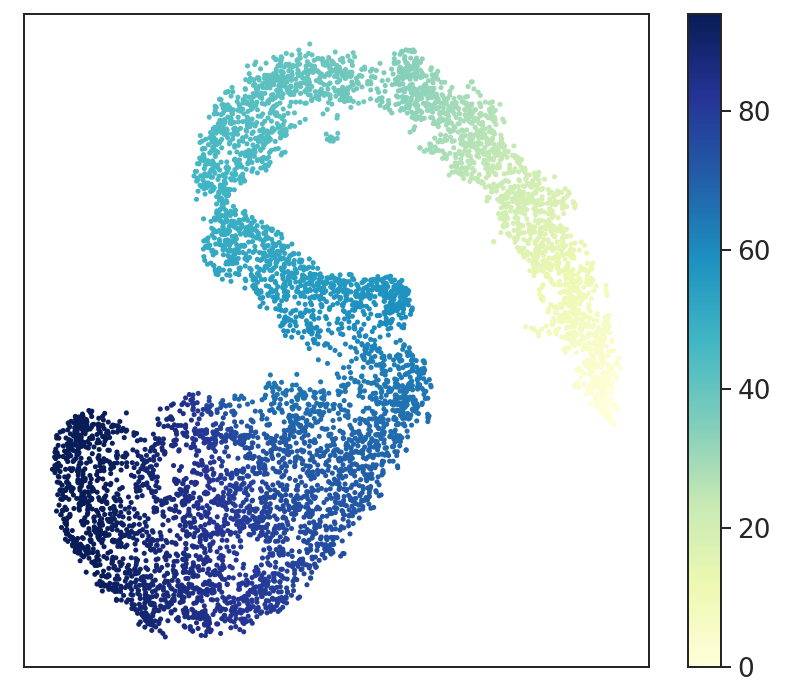

In [15]:
size = 3

fig = plt.figure(figsize=(7,6))
ax21 = plt.subplot(111)
g = ax21.scatter(tsne_df.loc[order_pseudo_cells].iloc[:,0],tsne_df.loc[order_pseudo_cells].iloc[:,1],
                 c=pseudo_df.loc[order_pseudo_cells,'Pseudotime'],
                 cmap='YlGnBu',s=size)
text = ax21.set_xticks([])
text = ax21.set_yticks([])
clb = plt.colorbar(g, fraction=0.15, ax=ax21, shrink=1)

# Fig 1C

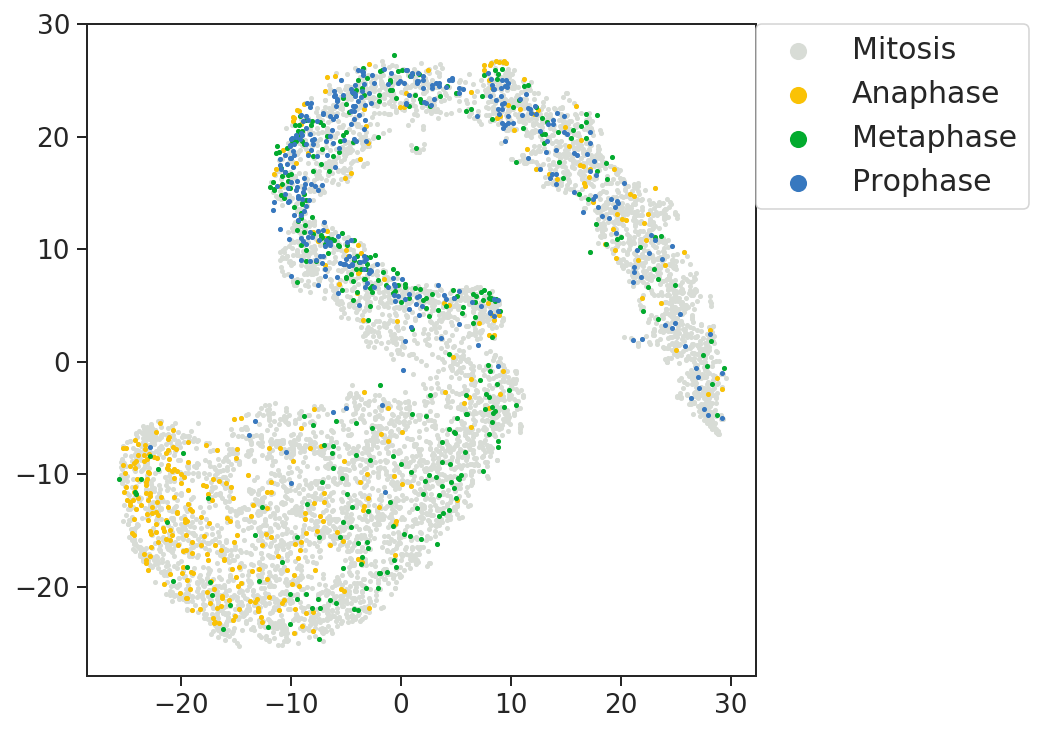

In [23]:
size = 3

fig = plt.figure(figsize=(6,6))
ax21 = plt.subplot(111)
ax21.scatter(tsne_df.iloc[:,0],tsne_df.iloc[:,1],color='#d8dcd6',s=size,label='Mitosis')
ax21.scatter(tsne_df.loc[ana_cells].iloc[:,0],tsne_df.loc[ana_cells].iloc[:,1],color='#fac205',label='Anaphase',s=size)
ax21.scatter(tsne_df.loc[met_cells].iloc[:,0],tsne_df.loc[met_cells].iloc[:,1],color='#02ab2e',label='Metaphase',s=size)
ax21.scatter(tsne_df.loc[pro_cells].iloc[:,0],tsne_df.loc[pro_cells].iloc[:,1],color='#3778bf',label='Prophase',s=size)
lgnd = ax21.legend(bbox_to_anchor=(1,1), loc=2, borderaxespad=0., prop={'size': 15})
for handle in lgnd.legendHandles:
    handle.set_sizes([60])

# Fig 1D

In [19]:
nb_pro = len([x for x in order_pseudo_cells if re.match('Lo2Pro',x)])
nb_met = len([x for x in order_pseudo_cells if re.match('Lo2Met',x)])
nb_ana = len([x for x in order_pseudo_cells if re.match('Lo2An',x)])

Text(1548.3, 0.5, 'Proportion')

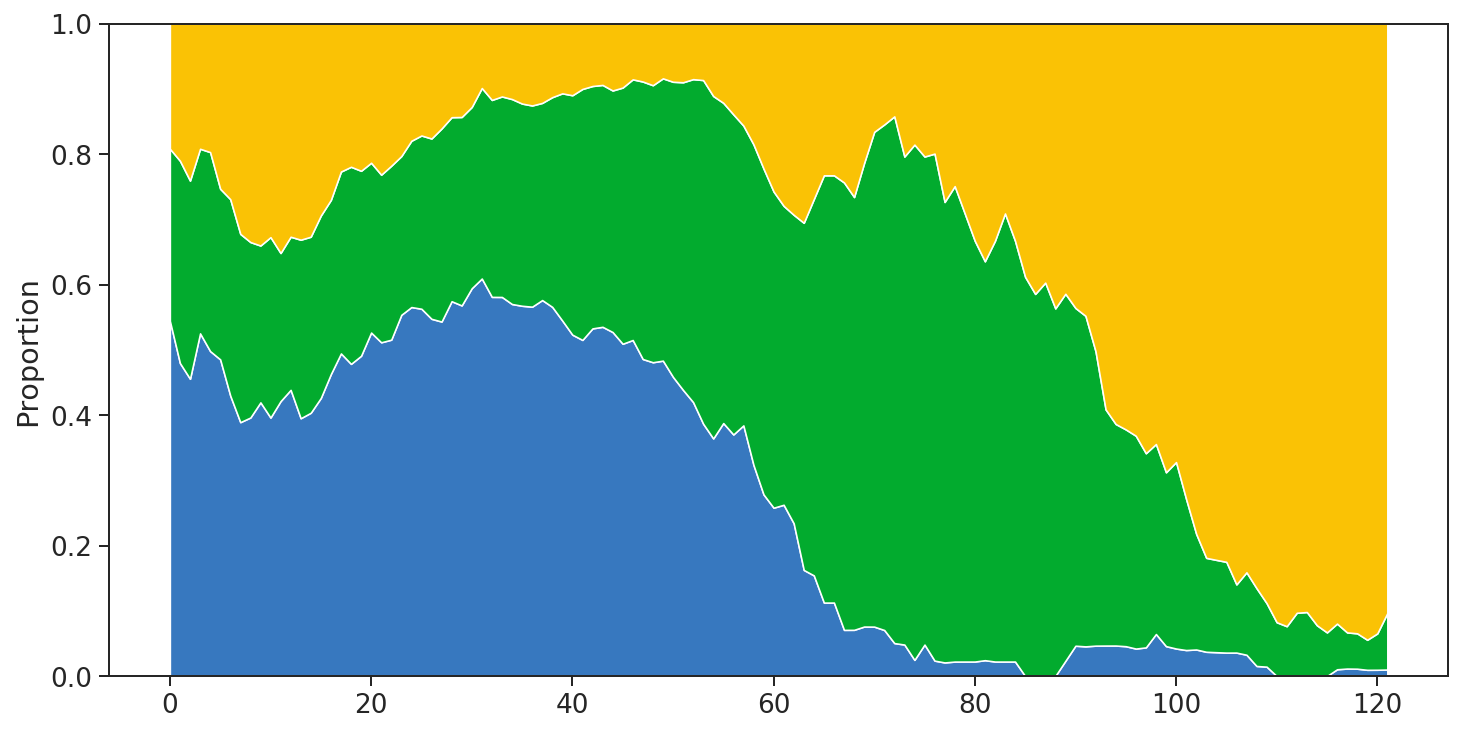

In [22]:
cell_parts = []
nb_metaCell = 500
nb_step = 50

for i in range(1000):
    tmp_start = i*nb_step
    tmp_end = nb_metaCell+i*nb_step
    if tmp_end > nb_cell:
        tmp_end = deepcopy(nb_cell)
        cell_parts.append(order_pseudo_cells[tmp_start:tmp_end])
        break
    cell_parts.append(order_pseudo_cells[tmp_start:tmp_end])

pro_ls = []
met_ls = []
ana_ls = []
allcell_ratio_ls = []

for cell_part in cell_parts:
    ratio_pro = len([x for x in cell_part if re.match('Lo2Pro',x)])/nb_pro
    ratio_met = len([x for x in cell_part if re.match('Lo2Met',x)])/nb_met
    ratio_ana = len([x for x in cell_part if re.match('Lo2An',x)])/nb_ana
    ratio_sum = ratio_pro + ratio_met + ratio_ana
    
    pro_ls.append(ratio_pro / ratio_sum)
    met_ls.append(ratio_met / ratio_sum)
    ana_ls.append(ratio_ana / ratio_sum)
    allcell_ratio_ls.append(len([x for x in cell_part if re.match('Lo2',x)])/nb_cell)

fig = plt.figure(figsize=(12,6))
ax21 = plt.subplot(111)
ax21.stackplot(range(len(pro_ls)),pro_ls,met_ls,ana_ls,
               labels=['Prophase','Metaphase','Anaphase'], 
               colors=['#3778bf','#02ab2e','#fac205'])
# ax21.legend(loc='best')
ax21.set_ylim([0,1])
ax21.set_ylabel('Proportion')

# ax22 = ax21.twinx()
# ax22.plot(range(len(pro_ls)),allcell_ratio_ls,c='black',linewidth=1)
# ax22.set_ylim([0,0.03])
ax22.set_ylabel('Proportion')

# Fig 1E and 1F

In [24]:
# gene_score_df = pd.read_csv('./Data/genes_scored_by_TSS_peaks.csv', 
#                             index_col=0, low_memory=False, engine='c')
gene_score_df = pd.read_csv('./Data/genes_scored_by_TSS_peaks.csv', 
                            index_col=0)
all_score_genes = list(gene_score_df.columns)

In [25]:
gene_score_df = gene_score_df.loc[tsne_df.index]

In [28]:
def Smooth2(gene):
    xx = pseudo_df.loc[order_pseudo_cells,'Pseudotime'].values
    xx = np.reshape(xx,newshape=(xx.shape[0],1))
    yy = gene_score_df.loc[order_pseudo_cells,gene].values
    
    gam = LinearGAM(n_splines=15).gridsearch(xx, yy)
    XX = gam.generate_X_grid(term=0, n=500)
    
    predict_y = gam.predict(XX)
    
    return XX,predict_y

[]

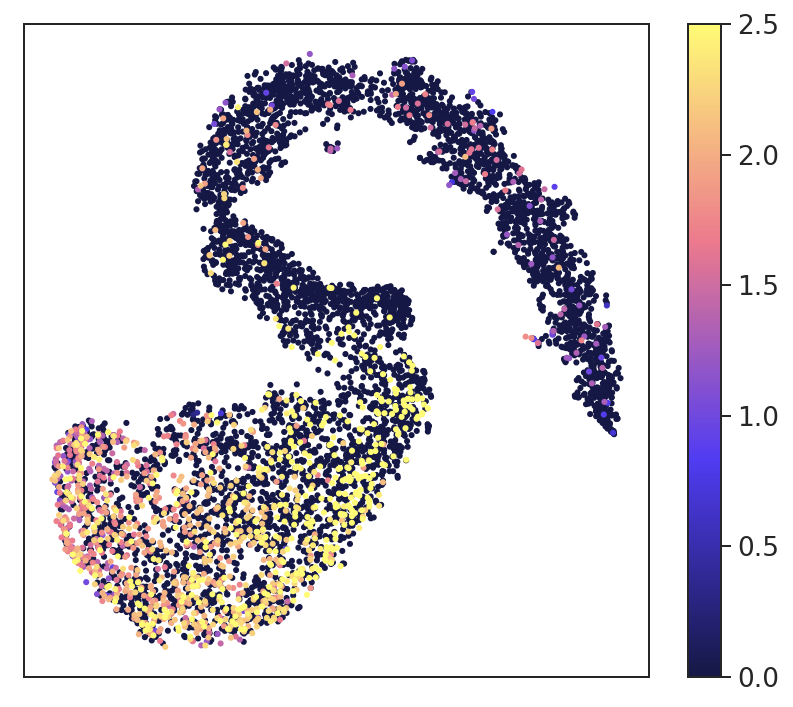

In [31]:
gene = 'TRIP13'
clim = [0,2.5]
sizes=5

fig = plt.figure(figsize=(7,6))
ax21 = plt.subplot(111)
order_gene_score_df = gene_score_df.sort_values(by=gene)
order_cells = order_gene_score_df.index.values
g = ax21.scatter(tsne_df.loc[order_cells].iloc[:,0], tsne_df.loc[order_cells].iloc[:,1],
                 c=order_gene_score_df[gene].values, cmap=cmap, s=sizes)
clb = plt.colorbar(g, fraction=0.15, ax=ax21,
             shrink=1)
g.set_clim(clim)
ax21.set_xticks([])
ax21.set_yticks([])

[]

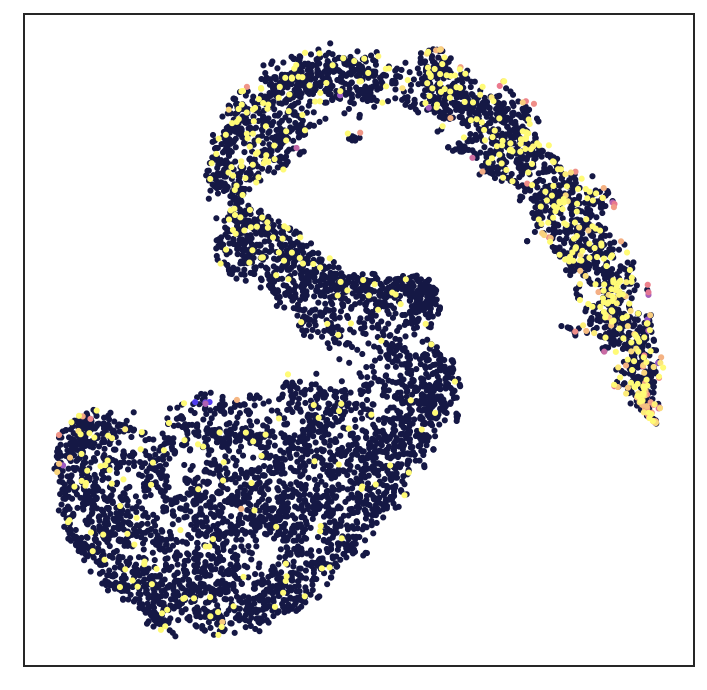

In [33]:
gene = 'TAOK2'
clim = [0,1.5]
sizes=5

fig = plt.figure(figsize=(6,6))
ax21 = plt.subplot(111)
order_gene_score_df = gene_score_df.sort_values(by=gene)
order_cells = order_gene_score_df.index.values
g = ax21.scatter(tsne_df.loc[order_cells].iloc[:,0], tsne_df.loc[order_cells].iloc[:,1],
                 c=order_gene_score_df[gene].values, cmap=cmap, s=sizes)
# clb = plt.colorbar(g, fraction=0.15, ax=ax21,
#              shrink=1)
g.set_clim(clim)
ax21.set_xticks([])
ax21.set_yticks([])